## Pyramid Blending and Feathering

<p style='direction:rtl; text-align: right'>
در این تمرین برای پیاده سازی روش، ابتدا دو تصویر و ماسک ترکیب کننده آن‌ها را دریافت میکنیم.
هرم لاپلاسین را به صورت iterative میسازیم و در راس هرم، دو تصویر را با پهنای باند معین (bandwidth_low) در مرز ماسک، با feathering ترکیب میکنیم
که در حقیقت ترکیب تصاویر در فرکانس‌های پایین است.
سپس هنگام collapse کردن هرم، هرم‌های دو تصویر را نیز با پهنای باند معینی به تعداد پیکسل برابر، لاپلاسین‌ها را با feathering
ترکیب میکنیم و پس از آن، طبقه هرم را collapse میکنیم.
<br>
هنگام ساخت هرم لاپلاسین، از اختلاف تصویر blurشده و تصویر اصلی استفاده میکنیم که این در حقیقت حکم فیلتر highpass را خواهد داشت.
بنابرین باید یک پارامتر cutoff برای مساله در نظر بگیریم که نشان دهنده معیار متمایز کننده فرکانس‌های بالا و پایین در هر طبقه از هرم باشد.
</p>

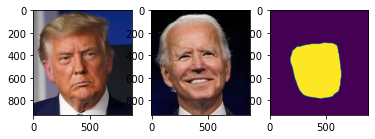

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import util, color

face1 = util.img_as_float64(plt.imread('2.target.jpg'))
face2 = util.img_as_float64(plt.imread('1.source.jpg'))
face_mask = color.rgb2gray(plt.imread('mask_trump_biden.png')[:, :, :3])

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(face1)
ax[1].imshow(face2)
ax[2].imshow(face_mask)
plt.show()

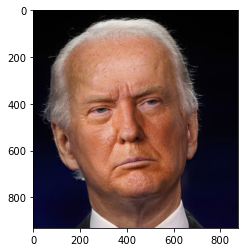

In [2]:
def pyr_up(src, cutoff, ratio):
    lowpassed = cv.GaussianBlur(src, (2 * cutoff + 1, 2 * cutoff + 1), 0,
                                borderType=cv.BORDER_REFLECT101)
    src -= lowpassed
    return cv.resize(lowpassed, (0, 0), None, ratio, ratio, cv.INTER_AREA)


def blend(src, tar, mask, bandwidth):
    mask = cv.GaussianBlur(mask, (2 * bandwidth + 1, 2 * bandwidth + 1), 0
                           , borderType=cv.BORDER_REFLECT101)[:, :, None]
    return src * mask + tar * (1 - mask)


iterations = 8
m_ratio = 0.8
bandwidth_low = 20
bandwidth_high = 40
m_cutoff = 8

pyr_lap_1 = [face1.copy()]
pyr_lap_2 = [face2.copy()]
pyr_mask = [face_mask.copy()]

for i in range(iterations):
    pyr_lap_1.append(pyr_up(pyr_lap_1[i], m_cutoff, m_ratio))
    pyr_lap_2.append(pyr_up(pyr_lap_2[i], m_cutoff, m_ratio))
    pyr_mask.append(cv.resize(pyr_mask[i], (0, 0), None, m_ratio, m_ratio, cv.INTER_NEAREST))

pyr_lap_1[iterations] = blend(pyr_lap_1[iterations], pyr_lap_2[iterations], pyr_mask[iterations], bandwidth_low)

for i in range(iterations - 1, -1, -1):
    pyr_lap_1[i] = blend(pyr_lap_1[i], pyr_lap_2[i], pyr_mask[i], bandwidth_high)
    tmp = cv.resize(pyr_lap_1[i + 1], pyr_lap_1[i].shape[:2][::-1], interpolation=cv.INTER_AREA)
    pyr_lap_1[i] += tmp

res = np.clip(pyr_lap_1[0], 0, 1)
plt.imshow(res)
plt.show()


